In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import imageio
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.utils import download_url
from torchvision.io import read_image
from IPython import display
import torchvision.transforms.functional as F_t
import math
from torchvision import transforms
import pickle

In [2]:
class ImageDataset(Dataset):
    def __init__(self, image_path):
        super().__init__()
        self.image_path = image_path

    def __getitem__(self, idx):
      image = read_image(self.image_path)
      image = F_t.convert_image_dtype(image, dtype=torch.float)
      image = image.permute(1, 2, 0)

      # Determine the side length of the square image
      min_dim = min(image.shape[:2])
      start_h = (image.shape[0] - min_dim) // 2
      start_w = (image.shape[1] - min_dim) // 2
      end_h = start_h + min_dim
      end_w = start_w + min_dim

      # Make sure dimensions are even
      if min_dim % 2 != 0:
          end_h -= 1
          end_w -= 1

      # Crop the image to make it square
      image = image[start_h:end_h, start_w:end_w]

      h_axis = torch.linspace(0, 1, steps=image.shape[0])
      w_axis = torch.linspace(0, 1, steps=image.shape[1])
      grid = torch.stack(torch.meshgrid(h_axis, w_axis), dim=-1)

      return grid, image

    def __len__(self):
        return 1

In [3]:
class FourierLayer(nn.Module):
    def __init__(self, in_features, out_features, scale):
        super().__init__()
        B = torch.randn(in_features, out_features)*scale
        self.register_buffer("B", B)
    
    def forward(self, x):
        x_proj = torch.matmul(2*math.pi*x, self.B)
        out = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
        return out


In [4]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, scale, fourier = True, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        
        if fourier == True:
            self.net.append(FourierLayer(in_features, hidden_features, scale))
            
            self.net.append(SineLayer(hidden_features*2, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))
        else:
            self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))
        

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [88]:
class Net(nn.Module):
    def __init__(self, input_size, num_channels, scale):
        super(Net,  self).__init__()
        self.ff = FourierLayer(input_size, num_channels, scale)
        self.fc1 = nn.Linear(2*num_channels, num_channels)
        self.fc2 = nn.Linear(num_channels, num_channels)
        self.fc3 = nn.Linear(num_channels, num_channels)
        self.fc4 = nn.Linear(num_channels, num_channels)
        self.fc5 = nn.Linear(num_channels, 3)
        
    def forward(self, x):
        x = self.ff(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return F.sigmoid(x)

## Setup and train Siren with and without Fourier features

In [172]:
# Download fox image, take a square crop from the center and load as dataset
image_url = 'https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg'
download_url(image_url, ".", "fox.jpg")
image_path = "fox.jpg"
image_data = ImageDataset(image_path)
image_loader = DataLoader(image_data, batch_size=1)

Using downloaded and verified file: .\fox.jpg


In [173]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device
input_size = 2
sc = 16
fourier_net = Siren(in_features=2, out_features=3, hidden_features=344, 
                  hidden_layers=3, outermost_linear=True, scale = sc, fourier = True).to(device)
siren_net = Siren(in_features=2, out_features=3, hidden_features=344, 
                  hidden_layers=3, outermost_linear=True, scale = sc, fourier = False).to(device)

x_test, img = next(iter(image_loader))
x_test, img = x_test.squeeze().to(device), img.squeeze().to(device)
train_coords, train_rgbs = x_test[::2, ::2].reshape(-1, 2), img[::2, ::2].reshape(-1, 3)  # use every other pixel for training
test_coords, test_rgbs = x_test.reshape(-1, 2), img.reshape(-1, 3)  # use all the pixels for evaluation

In [174]:
loss_criterion = nn.MSELoss()
optim_fourier = optim.Adam(fourier_net.parameters(), lr=1e-4)
optim_siren = optim.Adam(siren_net.parameters(), lr=1e-4)

In [175]:
# Lists to store train and test PSNRs
train_psnrs_fourier = []
train_psnrs_siren = []
test_psnrs_fourier = []
test_psnrs_siren = []

iters = 500

# Training loop
for i in tqdm(range(iters), desc='train iter', leave=False):
    
    # Forward pass
    train_output_fourier = fourier_net(train_coords)
    train_output_siren = siren_net(train_coords)
    
    # Calculate loss
    train_loss_fourier = loss_criterion(train_output_fourier[0], train_rgbs)
    train_loss_siren = loss_criterion(train_output_siren[0], train_rgbs)

    
    # Backward pass
    optim_fourier.zero_grad()
    optim_siren.zero_grad()
    train_loss_fourier.backward()
    train_loss_siren.backward()
    optim_fourier.step()
    optim_siren.step()
    
    # Evaluate PSNR
    if i % 5 == 0:
        fourier_net.eval()
        with torch.no_grad():
            prediction_fourier = fourier_net(test_coords)
            test_loss_fourier = F.mse_loss(prediction_fourier[0], test_rgbs)
            test_psnrs_fourier.append((-10*torch.log10(test_loss_fourier)).item())
            train_psnrs_fourier.append((-10*torch.log10(train_loss_fourier)).item())
            prediction_siren = siren_net(test_coords)
            test_loss_siren = F.mse_loss(prediction_siren[0], test_rgbs)
            test_psnrs_siren.append((-10*torch.log10(test_loss_siren)).item())
            train_psnrs_siren.append((-10*torch.log10(train_loss_siren)).item())

## Setup and train with only Fourier features

In [176]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device
num_channels = 344
input_size = 2
sc = 16
net = Net(2, num_channels = num_channels, scale = sc).to(device)

x_test, img = next(iter(image_loader))
x_test, img = x_test.squeeze().to(device), img.squeeze().to(device)
train_coords, train_rgbs = x_test[::2, ::2].reshape(-1, 2), img[::2, ::2].reshape(-1, 3)  # use every other pixel for training
test_coords, test_rgbs = x_test.reshape(-1, 2), img.reshape(-1, 3)  # use all the pixels for evaluation

In [177]:
loss_criterion = nn.MSELoss()
optim_net = optim.Adam(net.parameters(), lr=1e-4)

In [178]:
# Lists to store train and test PSNRs
test_psnrs_net = []
train_psnrs_net = []

iters = 500

# Training loop
for i in tqdm(range(iters), desc='train iter', leave=False):
    
    # Forward pass
    train_output = net(train_coords)
    
    # Calculate loss
    train_loss = loss_criterion(train_output, train_rgbs)

    
    # Backward pass
    optim_net.zero_grad()
    train_loss.backward()
    optim_net.step()
    
    # Evaluate PSNR
    if i % 5 == 0:
        net.eval()
        with torch.no_grad():
            prediction = net(test_coords)
            test_loss = F.mse_loss(prediction, test_rgbs)
            test_psnrs_net.append((-10*torch.log10(test_loss)).item())
            train_psnrs_net.append((-10*torch.log10(train_loss)).item())

train iter:   0%|                                                                              | 0/500 [00:00<?, ?it/s]D:\Anadonda\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


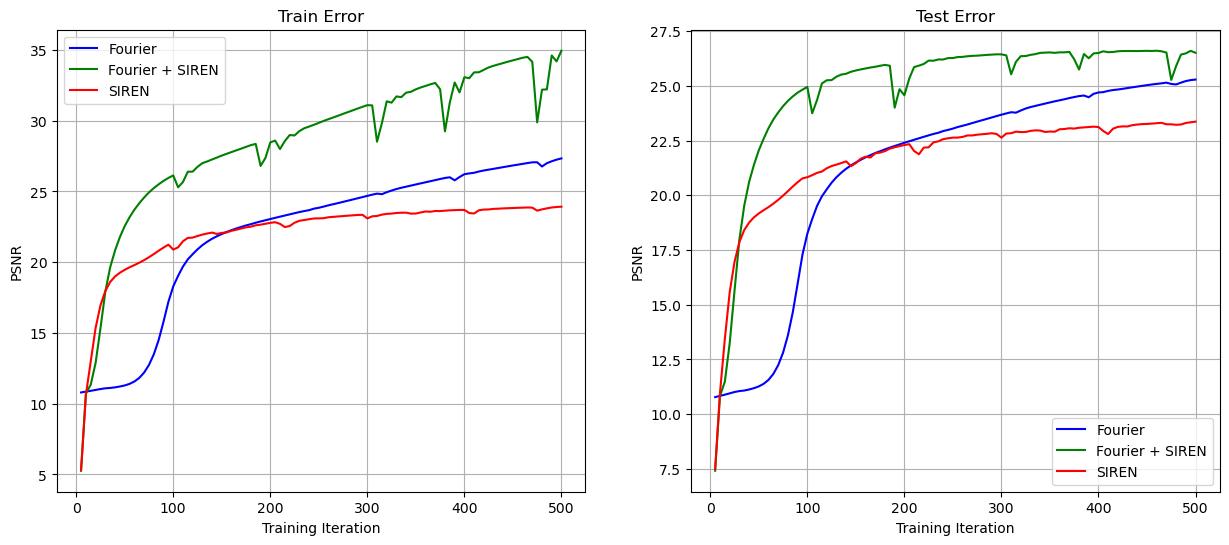

In [185]:
plt.figure(figsize=(15, 6))

epochs_per_data_point = 5
num_data_points = len(train_psnrs_net)
epochs_train = np.arange(epochs_per_data_point, epochs_per_data_point * num_data_points + 1, epochs_per_data_point)

# Plotting train PSNRs for Net
plt.subplot(1, 2, 1)
plt.plot(epochs_train, train_psnrs_net, label='Fourier', color='blue')

# Plotting train PSNRs for Fourier
plt.plot(epochs_train, train_psnrs_fourier, label='Fourier + SIREN', color='green')

# Plotting train PSNRs for SIREN
plt.plot(epochs_train, train_psnrs_siren, label='SIREN', color='red')

plt.title('Train Error')
plt.xlabel('Training Iteration')
plt.ylabel('PSNR')
plt.legend()
plt.grid(True)

# Plotting test PSNRs for Net
plt.subplot(1, 2, 2)
plt.plot(epochs_train, test_psnrs_net, label='Fourier', color='blue')

# Plotting test PSNRs for Fourier
plt.plot(epochs_train, test_psnrs_fourier, label='Fourier + SIREN', color='green')

# Plotting test PSNRs for SIREN
plt.plot(epochs_train, test_psnrs_siren, label='SIREN', color='red')

plt.title('Test Error')
plt.xlabel('Training Iteration')
plt.ylabel('PSNR')
plt.legend()
plt.grid(True)

plt.show()

## Perform inference and plot results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


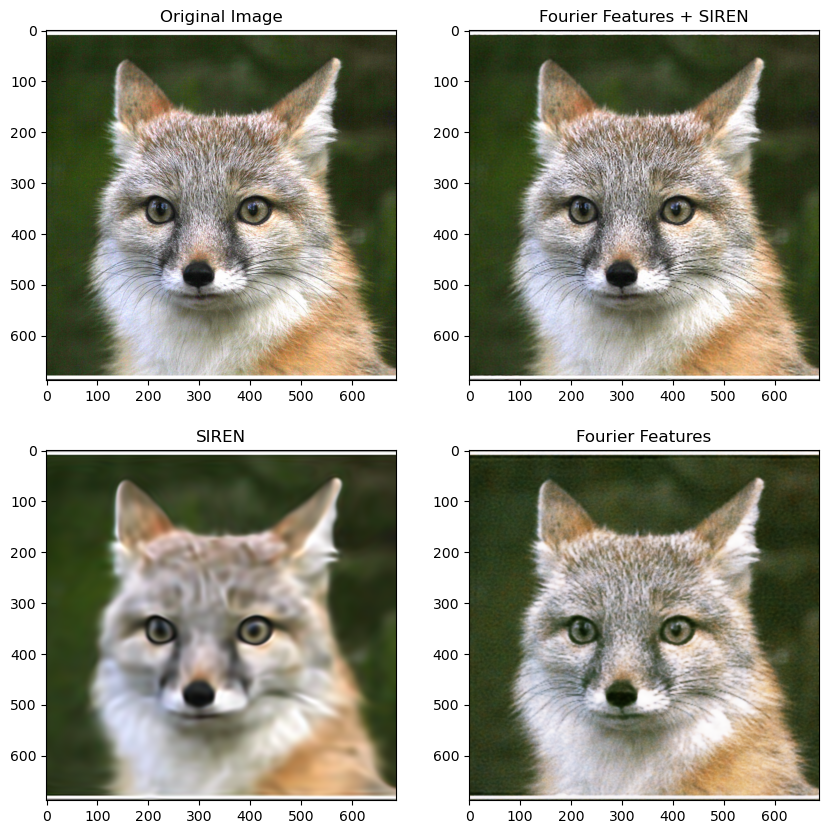

In [95]:
# Perform inference
with torch.no_grad():
    test_output_fourier = fourier_net(test_coords)
    test_output_siren = siren_net(test_coords)
    test_output_net = net(test_coords)

    #test_output_siren = siren_net(test_coords)


fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(img.cpu())  # Assuming img is the original image
axes[0, 0].set_title('Original Image')

axes[0, 1].imshow(test_output_fourier[0].reshape_as(img).cpu())  
axes[0, 1].set_title('Fourier Feautures + SIREN')

axes[1, 0].imshow(test_output_siren[0].reshape_as(img).cpu())  
axes[1, 0].set_title('SIREN')

axes[1, 1].imshow(test_output_net.reshape_as(img).cpu())  
axes[1, 1].set_title('Fourier Features')

for ax in axes.flatten():
    ax.axis('on')

plt.show()

## DIV-2K Dataset

In [5]:
image_path = "C:/Users/Bobby/Downloads/archive (2)/DIV2K_train_HR\DIV2K_train_HR/0001.png"
image_data = ImageDataset(image_path)
image_loader = DataLoader(image_data, batch_size=1)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device
input_size = 2
sc = 16
fourier_net = Siren(in_features=2, out_features=3, hidden_features=300, 
                  hidden_layers=3, outermost_linear=True, scale = sc, fourier = True).to(device)

x_test, img = next(iter(image_loader))
x_test, img = x_test.squeeze().to(device), img.squeeze().to(device)
train_coords, train_rgbs = x_test[::8, ::8].reshape(-1, 2), img[::8, ::8].reshape(-1, 3)  # use every other pixel for training
test_coords, test_rgbs = x_test.reshape(-1, 2), img.reshape(-1, 3)  # use all the pixels for evaluation

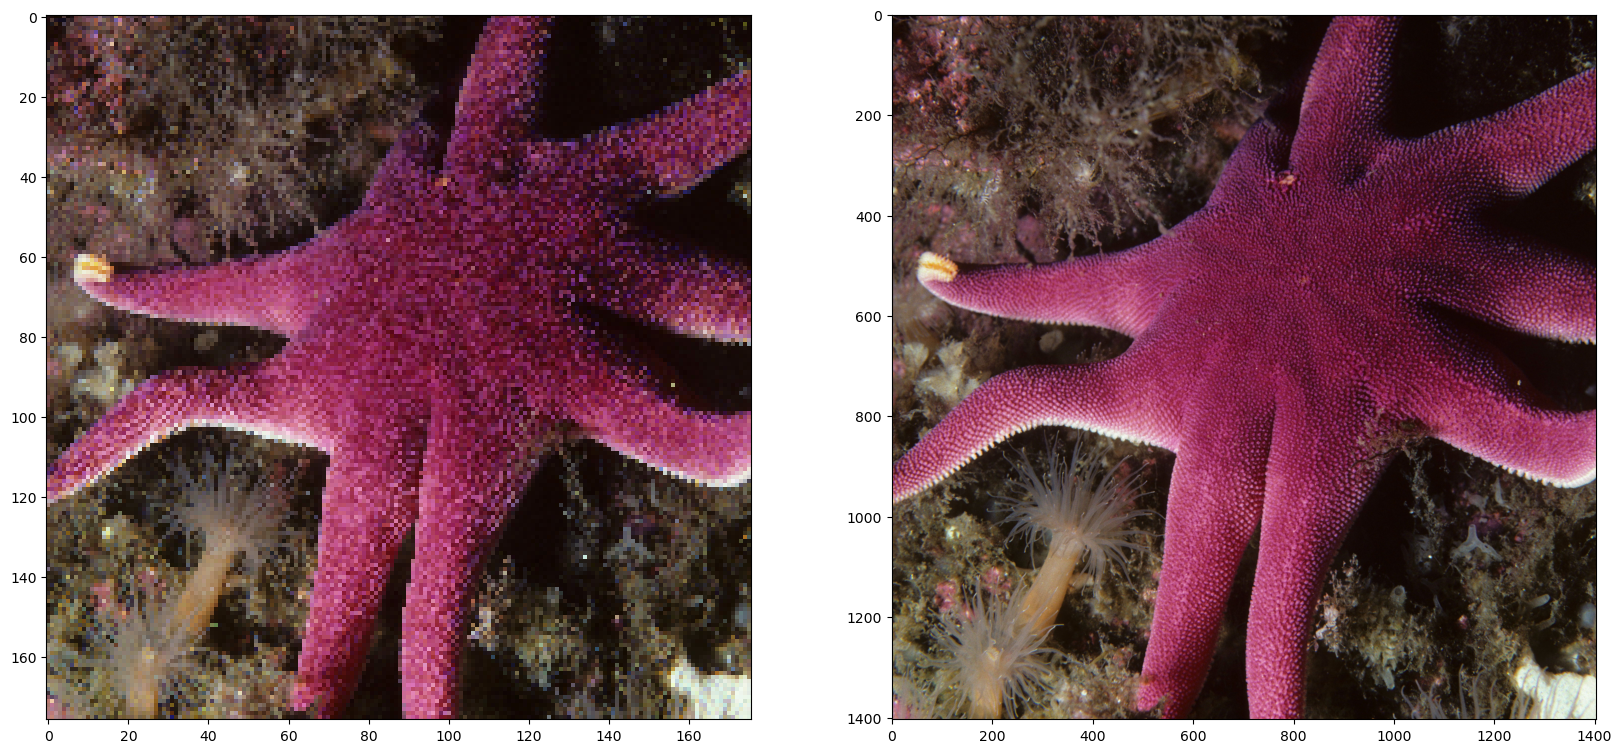

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img[::8, ::8].cpu())
#axes[1].imshow(test_output_siren[0].reshape_as(img).cpu())
axes[1].imshow(img.cpu())
plt.axis('on')
plt.show()

In [17]:
loss_criterion = nn.MSELoss()
optim_fourier = optim.Adam(fourier_net.parameters(), lr=1e-4)

In [18]:
train_psnrs_net = []
test_psnrs_net = []

# Lists to store train and test PSNRs
train_psnrs = []
iters = 500

# Training loop
for i in tqdm(range(iters), desc='train iter', leave=False):
    
    # Forward pass
    train_output_fourier = fourier_net(train_coords)
    #train_output_siren = siren_net(train_coords)
    
    # Calculate loss
    train_loss_fourier = loss_criterion(train_output_fourier[0], train_rgbs)
    #train_loss_siren = loss_criterion(train_output_siren[0], train_rgbs)

    
    # Backward pass
    optim_fourier.zero_grad()
    #optim_siren.zero_grad()
    train_loss_fourier.backward()
    #train_loss_siren.backward()
    optim_fourier.step()
    #optim_siren.step()
    
    if i % 5 == 0:
        fourier_net.eval()
        with torch.no_grad():
            prediction = fourier_net(test_coords)
            test_loss = F.mse_loss(prediction[0], test_rgbs)
            test_psnrs_net.append((-10*torch.log10(test_loss)).item())
            train_psnrs_net.append((-10*torch.log10(train_loss_fourier)).item())
    
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


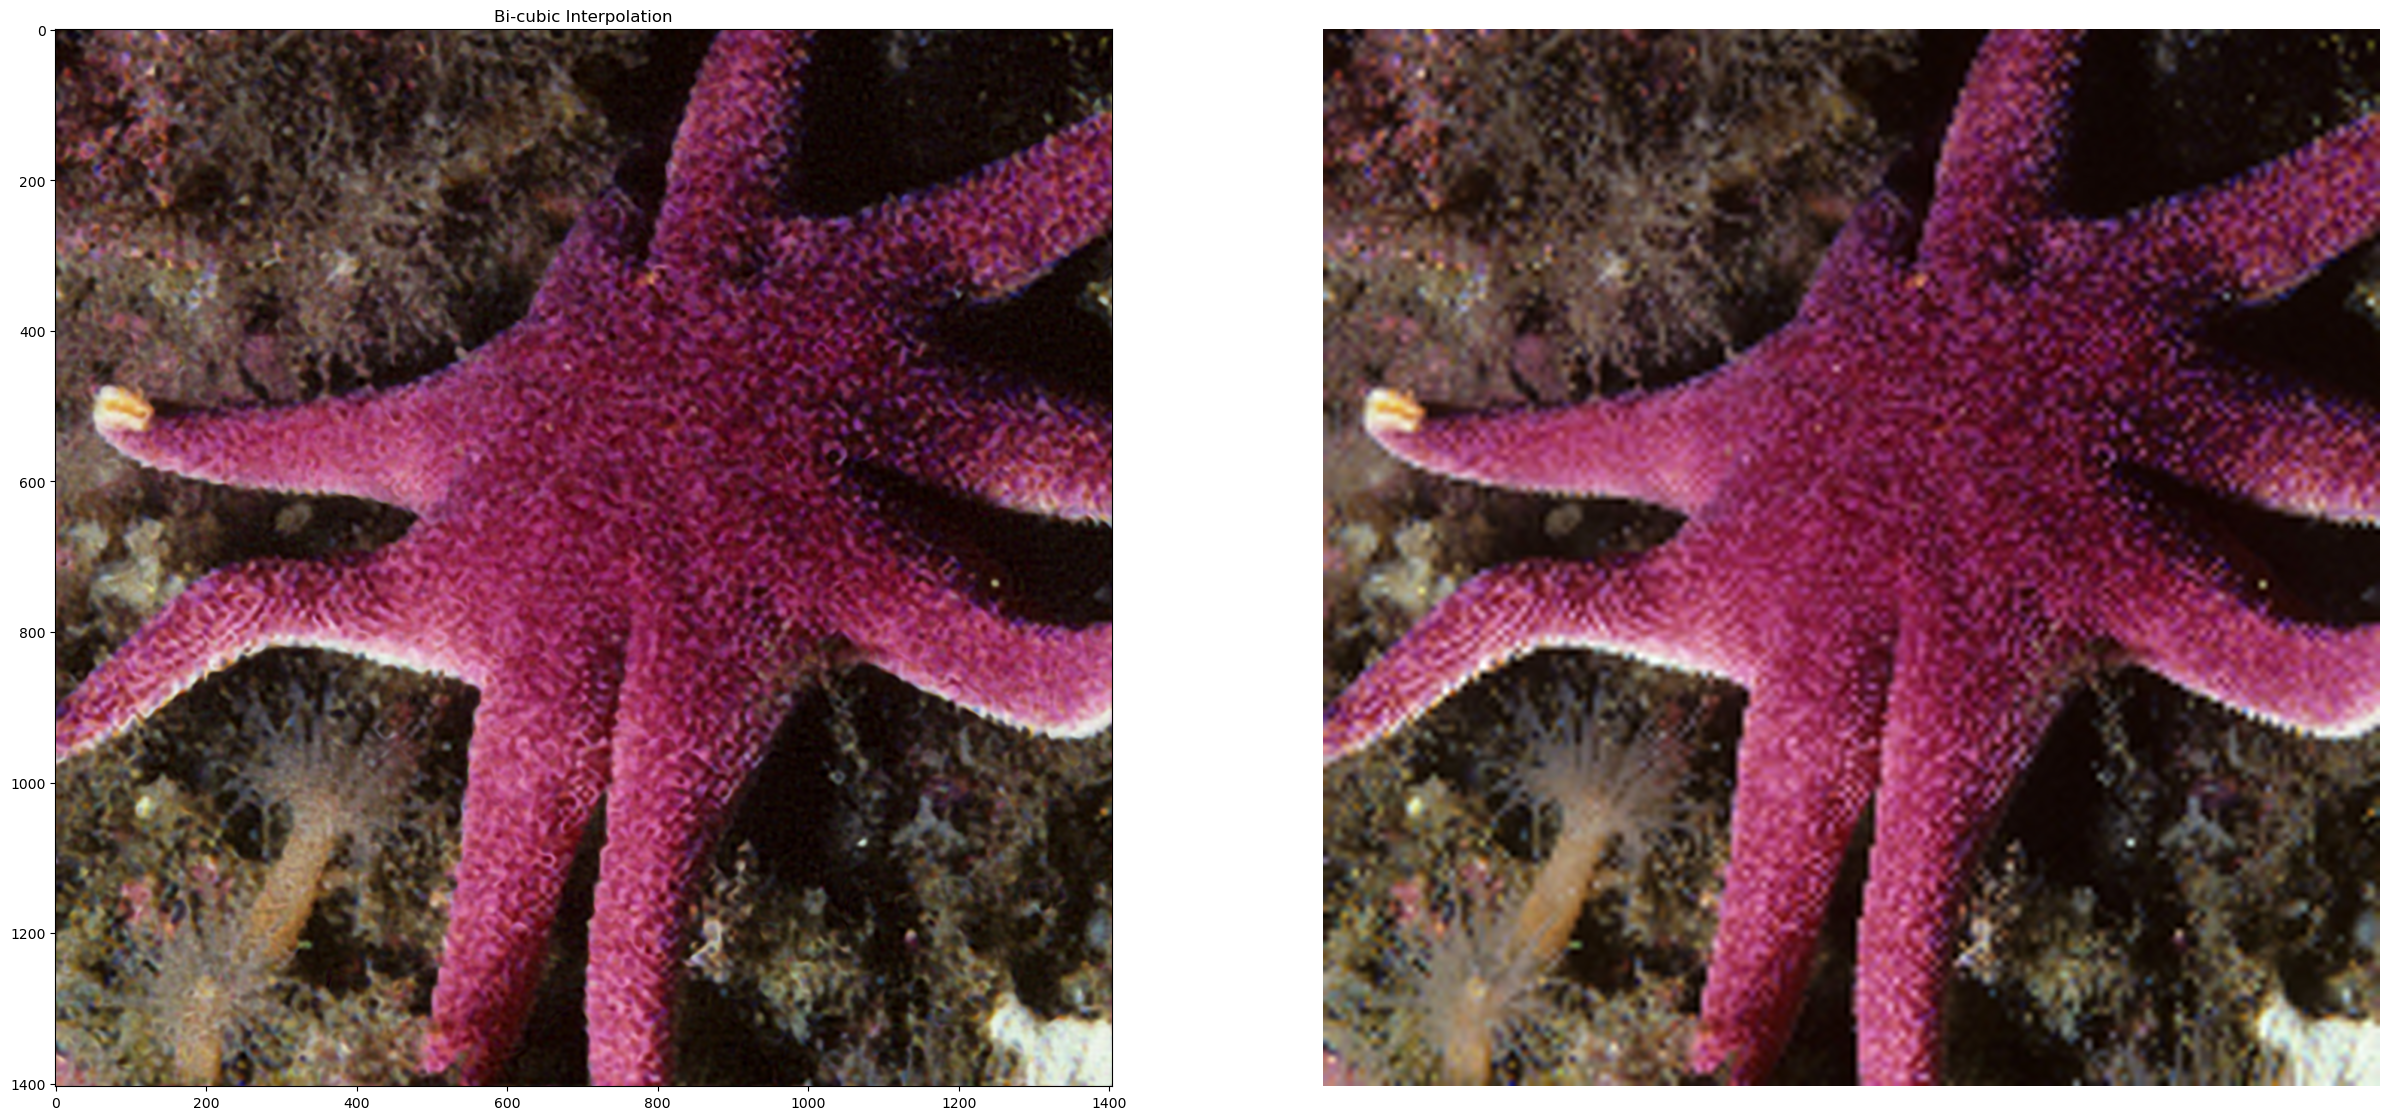

In [20]:
# Perform inference
with torch.no_grad():
    test_output_fourier = fourier_net(test_coords)

# compare with interpolation
int_rgb = img[::8, ::8]

upsampled_r = F.interpolate(int_rgb[:, :, 0].unsqueeze(0).unsqueeze(0), scale_factor=8, mode='bicubic').squeeze(0).squeeze(0)
upsampled_g = F.interpolate(int_rgb[:, :, 1].unsqueeze(0).unsqueeze(0), scale_factor=8, mode='bicubic').squeeze(0).squeeze(0)
upsampled_b = F.interpolate(int_rgb[:, :, 2].unsqueeze(0).unsqueeze(0), scale_factor=8, mode='bicubic').squeeze(0).squeeze(0)

# Stack the upsampled color channels back together
int_rgb = torch.stack([upsampled_r, upsampled_g, upsampled_b], dim=-1)

# Visualize the output
fig, axes = plt.subplots(1, 2, figsize=(30, 20))
axes[0].imshow(test_output_fourier[0].reshape(1404, 1404, 3).cpu())
axes[0].set_title('Fourier + SIREN')

#axes[1].imshow(test_output_siren[0].reshape_as(img).cpu())
axes[1].imshow(int_rgb.cpu())
axes[0].set_title('Bi-cubic Interpolation')

plt.axis('off')
plt.show()